# From Linear Regression to Hierarchical Models

In [1]:
import numpy as np
import pymc as pm
import arviz as az
import polars as pl
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
import matplotlib.pyplot as plt

# Visual style
az.style.use('arviz-doc')
pio.templates.default = 'plotly_white'

# Plotly defaults
px.defaults.template = 'plotly_white'
px.defaults.width = 900
px.defaults.height = 500
_base = pio.templates['plotly_white']
_tmpl = go.layout.Template(_base)
_tmpl.layout.hovermode = 'x unified'
pio.templates['hoverx'] = _tmpl
pio.templates.default = 'plotly_white+hoverx'

# Reproducibility
RANDOM_SEED = 20090425
RNG = np.random.default_rng(RANDOM_SEED)


# Generalized Linear Models (GLMs)

In the previous section, we worked with linear regression where the outcome variable was continuous and could be reasonably modeled with a normal distribution. However, many real-world outcomes don't fit this comfortable framework. Consider these common scenarios:

- **Count data**: Number of accidents at an intersection, disease cases in a population, customer complaints per day, goals scored in a match
- **Binary outcomes**: Customer churn (yes/no), disease presence (positive/negative), loan default (yes/no), email clicked (yes/no)
- **Proportions**: Market share, exam pass rates, survey response rates, survival probabilities
- **Strictly positive continuous**: Waiting times, insurance claim amounts, reaction times, rainfall amounts
- **Ordinal data**: Customer satisfaction (1-5 stars), pain levels, educational attainment levels

Trying to force these into a linear regression framework with normal errors often fails spectacularly:
- Predictions can be nonsensical (negative counts, probabilities > 1)
- Variance assumptions are violated (variance often depends on mean)
- Inference is invalid (confidence intervals include impossible values)
- Relationships are misspecified (effects are often multiplicative, not additive)

Generalized Linear Models (GLMs) elegantly solve these problems by extending the linear regression framework in two key ways.

## Poisson regression: Unbounded count data

This model is inspired by [a project by Ian Osvald](http://ianozsvald.com/2016/05/07/statistically-solving-sneezes-and-sniffles-a-work-in-progress-report-at-pydatalondon-2016/), which is concerned with understanding the various effects of external environmental factors upon the allergic sneezing of a test subject.

We're going to work with simpler data than the original study, which will allow you to clearly see the modeling stakes.

In [2]:
sneezes = pl.read_csv("../data/poisson_sneeze.csv")
sneezes.head()

nsneeze,alcohol,meds
i64,i64,i64
2,0,1
2,0,1
0,0,1
1,0,1
3,0,1


+ The subject sneezes N times per day, recorded as `nsneeze (int)`. The data are aggregated per day, to yield a total count of sneezes on that day.
+ The subject may or may not drink alcohol during that day, recorded as `alcohol (boolean)`
+ The subject may or may not take an antihistamine medication during that day, recorded as `meds (boolean)`

We assume that sneezing occurs at some baseline rate, which increases if an antihistamine is not taken, and further increases if alcohol is consumed.

### Visualize the data and set up the model

In [3]:
fig = make_subplots(rows=2, cols=2, 
                   subplot_titles=["meds=0, alcohol=0", "meds=1, alcohol=0",
                                  "meds=0, alcohol=1", "meds=1, alcohol=1"])

for i, alc in enumerate([0, 1]):
    for j, med in enumerate([0, 1]):
        filtered_data = sneezes.filter((pl.col('alcohol') == alc) & (pl.col('meds') == med))
        counts = filtered_data.get_column('nsneeze').value_counts().sort('nsneeze')
        
        fig.add_trace(
            go.Bar(x=counts.get_column('nsneeze'), y=counts.get_column('count'), marker_color='blue'),
            row=i+1, col=j+1
        )

fig.update_layout(
    height=600, 
    width=800,
    showlegend=False,
    title_text="Distribution of Sneezes by Medication and Alcohol"
)
fig.update_xaxes(title_text="Number of Sneezes")
fig.update_yaxes(title_text="Count")


The usual way of thinking about data coming from a Poisson distribution is as number of occurences of an event in a *given timeframe*. Here *number of sneezes per day*. The intensity parameter $\lambda$ specifies how many occurences we expect.

A nice property of the Poisson is that it's defined with only one parameter $\lambda$, which describes both the mean and variance of the Poisson, can be interpreted as the rate of events per unit -- here, if we inferred $\lambda = 2.8$, that would mean the subject is thought to sneeze about 2.8 times per day (implying in addition a $2.8$ variance).

In statistical terms, that means our likelihood is 

$$ Y_{\text{sneeze}} \sim \mathrm{Poisson}(\lambda)$$

> The Poisson probability mass function is:
>
> $$ P(Y=k|\lambda) = \frac{\lambda^k e^{-\lambda}}{k!} $$
>
> where $k$ is the number of occurrences (sneezes in our case) and $\lambda$ is the rate parameter.
>


Now, we need a prior on $\lambda$ ...

This is where the regression component comes in: remember that we want to infer the effect of meds and alcohol on the number of sneezes. So, we can use the usual linear regression formula we are familiar with: 

$$\lambda = \alpha + \beta_{\text{meds}} * \text{meds} + \beta_{\text{alcohol}} * \text{alcohol}$$

We will specify **weakly-informative priors** on the model latent variables.

$$
\begin{aligned}
\alpha &\sim \mathrm{Normal}(0, 5)\\
\beta_{\text{meds}}, \beta_{\text{alcohol}} &\sim \mathrm{Normal}(0, 1)\\
\lambda &= \alpha + \beta_{\text{meds}} * \text{meds} + \beta_{\text{alcohol}} * \text{alcohol}\\
Y_{\text{sneeze}} &\sim \mathrm{Poisson}(\lambda)\\
\end{aligned}
$$

In [19]:
len(sneezes)

4000

In [27]:
COORDS = {
    "regressor": ["meds", "alcohol"], 
    "obs_idx": range(len(sneezes))
}

M, A, S = sneezes.select(["meds", "alcohol", "nsneeze"]).to_numpy().T

with pm.Model(coords=COORDS) as m_sneeze:
    # weakly informative Normal Priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")

    # define linear model
    mu = pm.Deterministic("mu", a + b[0] * M + b[1] * A, dims="obs_idx")

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=mu, observed=S, dims="obs_idx")

### Model Fitting

Most GLMs will be fit using the NUTS step method.

In [28]:
with m_sneeze:
    trace_sneeze = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 4 seconds.


In [29]:
az.summary(trace_sneeze, var_names=["intercept", "slopes"])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,15.012,0.135,14.767,15.266,0.004,0.003,922.0,1375.0,1.0
slopes[meds],-14.381,0.135,-14.633,-14.135,0.004,0.003,921.0,1335.0,1.0
slopes[alcohol],7.278,0.120,7.060,7.506,0.004,0.002,1088.0,1463.0,1.0


While the model sampled to completion, close inspection of the model reveals an issue that could have caused the sampler to fail. Can you spot it? In previous versions of PyMC, this model would have failed to sample.

Propose a more robust version below.

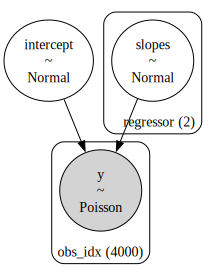

In [32]:
with pm.Model(coords=COORDS) as m_sneeze:
    # weakly informative Normal Priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")

    # define linear model
    mu = pm.math.exp(a + b[0] * M + b[1] * A)

    ## Define Poisson likelihood
    y = pm.Poisson("y", mu=mu, observed=S, dims="obs_idx")

pm.model_to_graphviz(m_sneeze)

Before looking at the results, let's take a step back: the trick we used with the exponential is actually exactly how generalized linear models are defined. The exponential here is called **a link function**, and it's used to map the **output of our linear model** (a priori allowed to live in $(-\infty, \infty)$,

### Link functions

In Generalized Linear Models (GLMs), link functions play a crucial role in connecting the linear predictor to the response variable. The concept of link functions arises from the need to model the relationship between the mean of the response variable and the linear predictor, which can take any real value.

The link function transforms the linear predictor to ensure that the predicted values of the response variable are within a valid range and satisfy the distributional assumptions of the response variable. It maps the linear predictor to the space of the relevant parameter of the response distribution.

Different types of GLMs use different link functions based on the nature of the response variable and the desired distribution. Some commonly used link functions include:

1. Identity Link: This link function is used for continuous response variables and maintains a linear relationship between the linear predictor and the mean of the response variable.

2. Logit Link: This link function is used for binary response variables and maps the linear predictor to the probability of success in a logistic regression model. It ensures that the predicted probabilities are between 0 and 1.

3. Log Link: This link function is used for count data and maps the linear predictor to the mean of a Poisson distribution. It ensures that the predicted mean is positive.

4. Inverse Link: This link function is used for modeling the mean of a Gamma distribution and maps the linear predictor to the inverse of the mean.

The choice of the link function depends on the nature of the response variable and the assumptions of the distribution. The link function allows for flexible modeling of the relationship between the linear predictor and the response variable, enabling the estimation of regression coefficients and making predictions within the appropriate range of the response distribution.

### Checking our inferences

Now is the time to check if our model's results are credible, via posterior predictive checks, to which we were introduced in the previous section.

In [33]:
with m_sneeze:

    # Get posterior predictive samples, and add them to the InferenceData object
    trace_sneeze.extend(pm.sample_posterior_predictive(trace_sneeze))

Sampling: [y]


Output()

Let's plot the posterior predictive checks for all the groups.

In [ ]:
def plot_sneeze_predictions(idata):
    fig, axs = plt.subplots(2, 2, figsize=(12, 8))

    az.plot_ppc(
        idata,
        ax=axs[0, 0],
        coords={
            "obs_idx": np.where(np.logical_and(sneezes.get_column("alcohol").to_numpy() == 0, sneezes.get_column("meds").to_numpy() == 0))
        },
    )
    az.plot_ppc(
        idata,
        ax=axs[0, 1],
        coords={
            "obs_idx": np.where(np.logical_and(sneezes.get_column("alcohol").to_numpy() == 0, sneezes.get_column("meds").to_numpy() == 1))
        },
    )
    az.plot_ppc(
        idata,
        ax=axs[1, 0],
        coords={
            "obs_idx": np.where(np.logical_and(sneezes.get_column("alcohol").to_numpy() == 1, sneezes.get_column("meds").to_numpy() == 0))
        },
    )
    az.plot_ppc(
        idata,
        ax=axs[1, 1],
        coords={
            "obs_idx": np.where(np.logical_and(sneezes.get_column("alcohol").to_numpy() == 1, sneezes.get_column("meds").to_numpy() == 1))
        },
    )
    axs[0, 0].set_title("No alcohol : No meds")
    axs[0, 1].set_title("No alcohol : Meds")
    axs[1, 0].set_title("Alcohol : No meds")
    axs[1, 1].set_title("Alcohol : Meds")
    return fig, axs

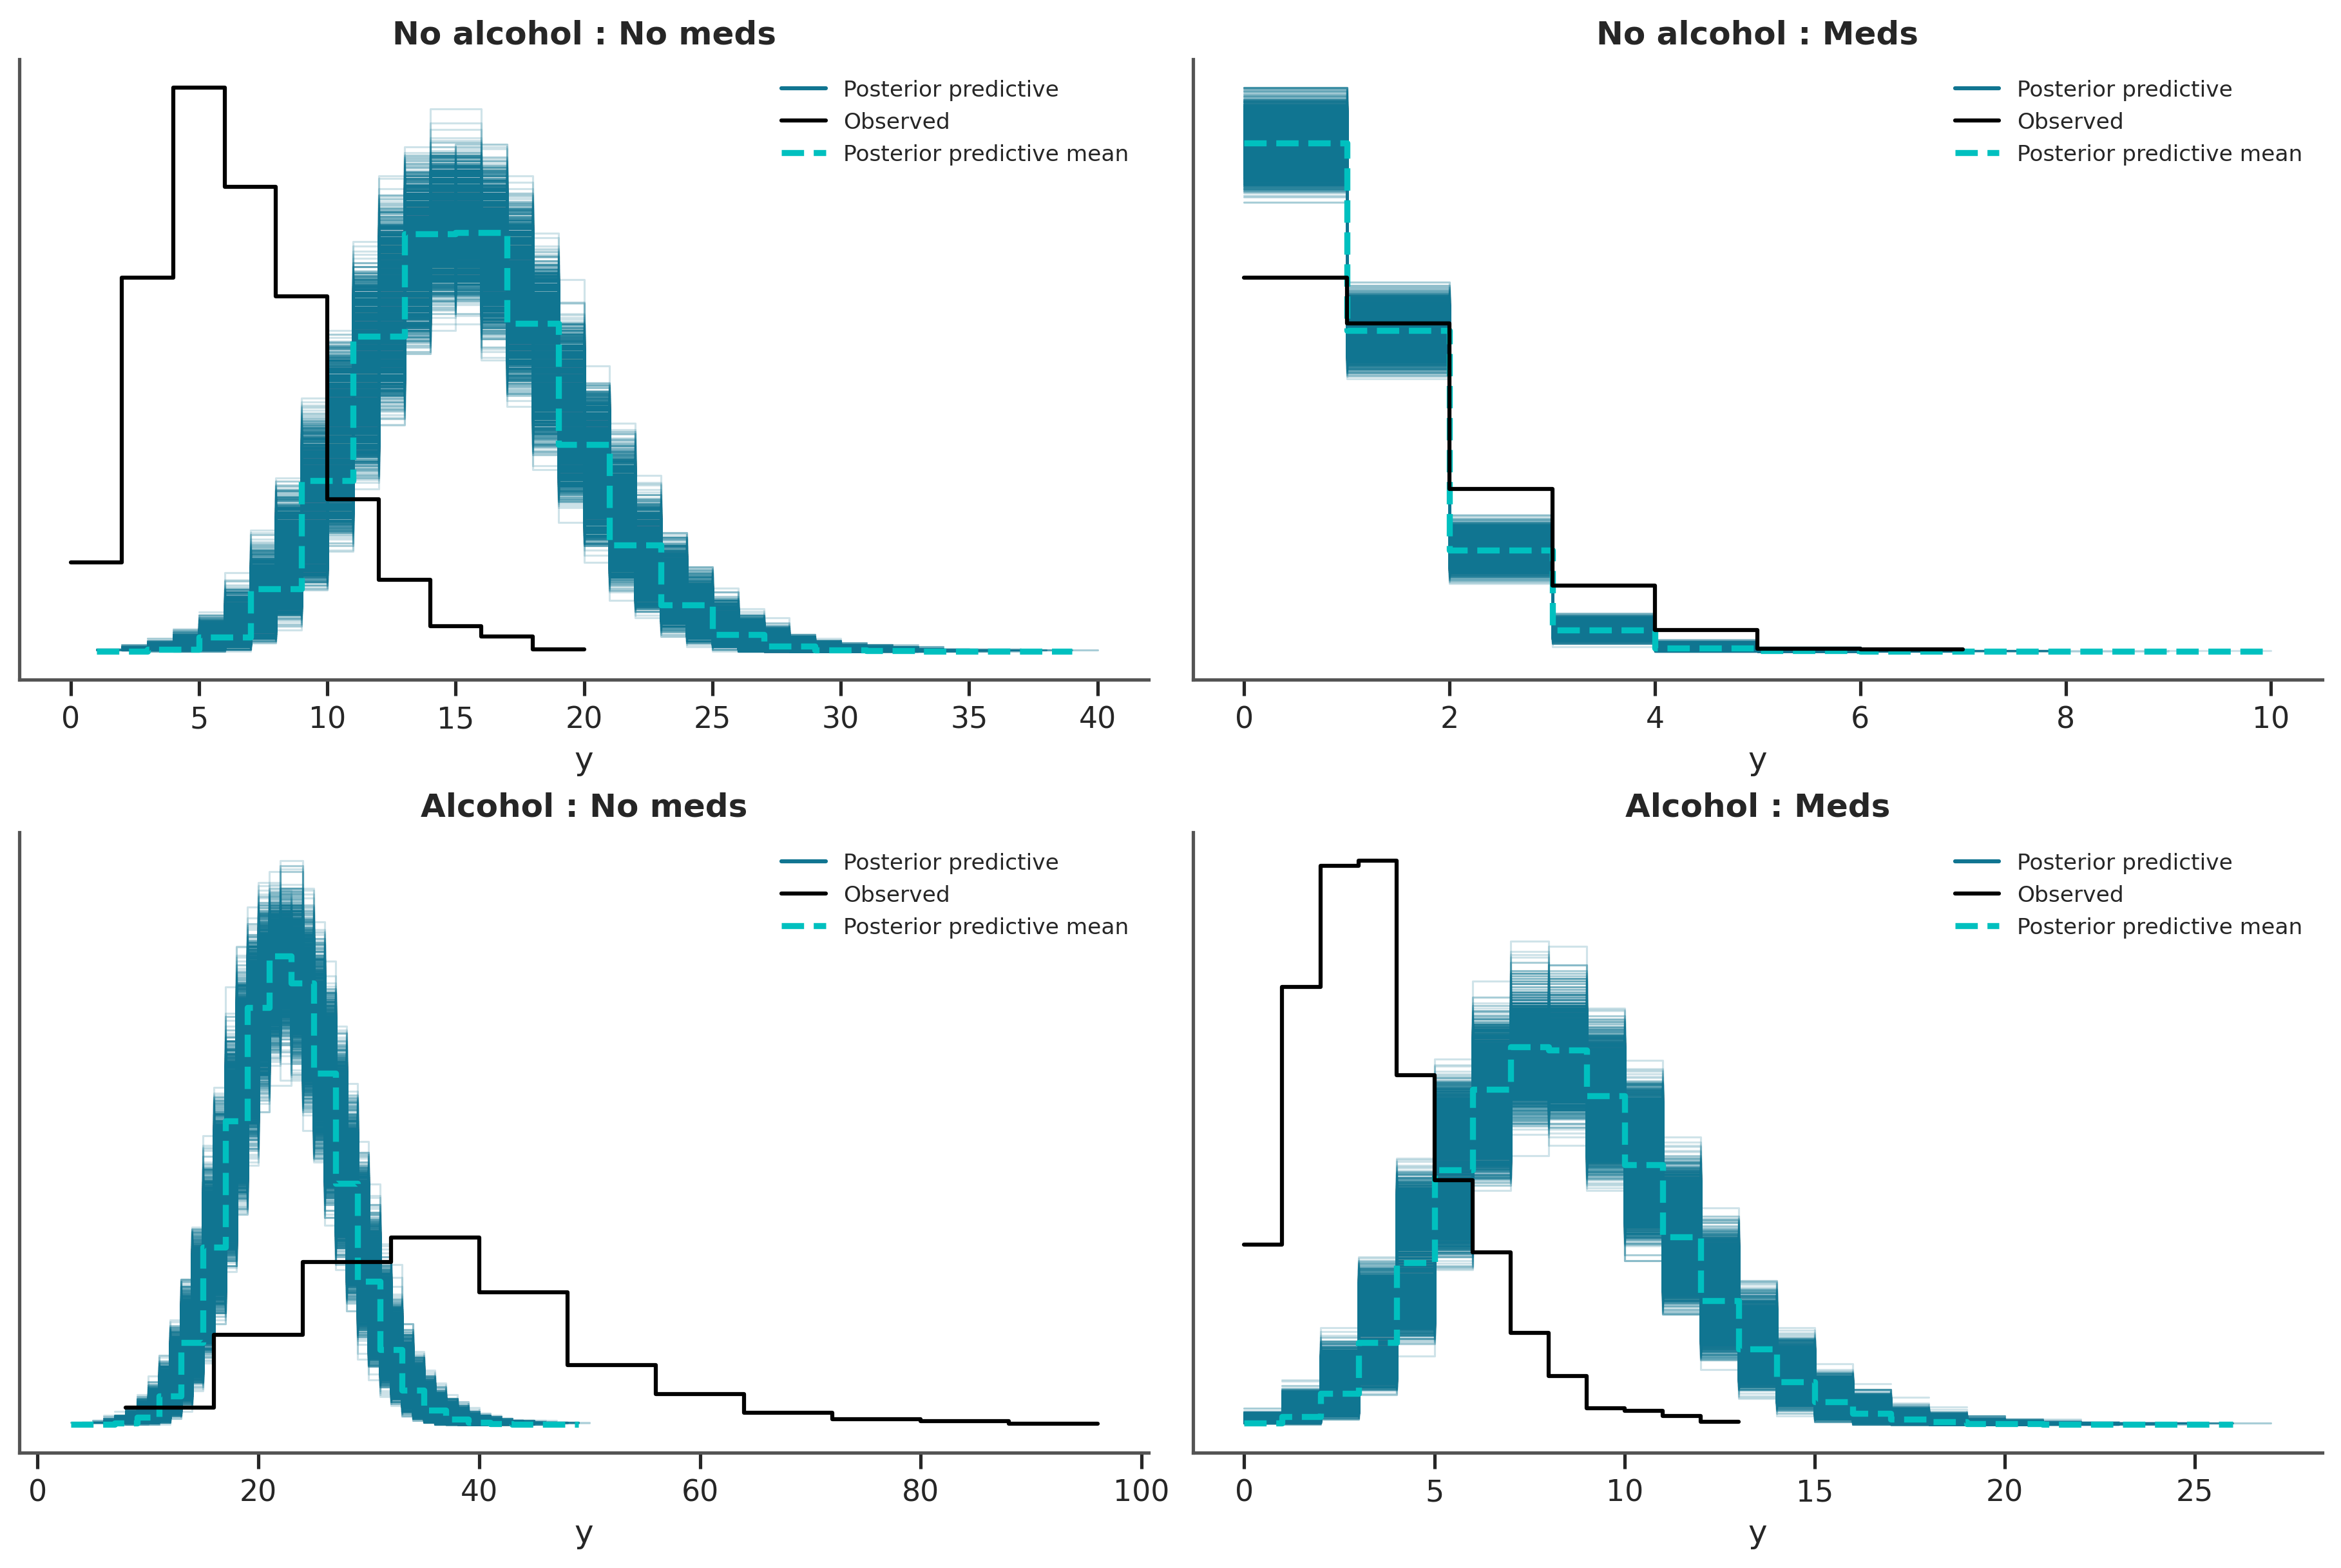

In [34]:
plot_sneeze_predictions(trace_sneeze);

While the model is in the ballpark of the actual data, it is not perfect. The model is underestimating the variance in the data. This is a common issue with Poisson regression, as the variance is constrained to be equal to the mean. When the data's mean and variance are not similar, a Poisson regression will underestimate the variance compared to the true variance observed in the data.

This behavior is quite common with Poisson regression: it often underestimates the variation in the data, simply because real data are more dispersed than our regression expects -- in these cases, data are said to be "overdispersed".

This phenomenon is particularly acute with the Poisson, because as we have seen its variance is mathematically constrained to be equal to its mean. So, when the data's mean and variance are not similar, a Poisson regression will get the variance estimate wrong when compared to the true variance observed in the data.

To convince ourselves, let's compare our data's mean and variance:

In [11]:
sneezes.group_by(["meds", "alcohol"]).agg([
    pl.col("nsneeze").mean().alias("mean"),
    pl.col("nsneeze").var().alias("var")
]).sort(["meds", "alcohol"])

meds,alcohol,mean,var
i64,i64,f64,f64
0,0,5.996,9.557542
0,1,36.006,158.450414
1,0,1.005,1.134109
1,1,3.099,4.255454


Notice that for each combination of `alcohol` and `meds`, the variance of `nsneeze` is higher than the mean!

## Gamma-Poisson Model

Gamma-Poisson (aka [Negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution)) regression is used to model overdispersion in count data. The Gamma-Poisson distribution can be thought of as a Poisson distribution whose rate parameter is gamma distributed, so that rate parameter can be adjusted to account for the increased variance. If you want more details about these models (a.k.a. "continuous mixture models"), I refer you to chapter 12 of [Richard McElreath's excellent _Statistical Rethinking_](https://nbviewer.jupyter.org/github/pymc-devs/resources/blob/master/Rethinking_2/Chp_12.ipynb).

In addition to the Poisson rate, $\lambda$, Gamma-Poisson distributions are parametrized an additional overdispersion parameter, $\alpha$, which controls the shape of the Gamma distribution. 

_The Gamma-Poisson distribution_

We start with a random variable $Y$ that follows a Poisson distribution with rate $\lambda$. Turns out $\lambda$ is also random, and it follows a gamma distribution with parameters $\mu$ and $\alpha$

$$
\begin{aligned}
Y &\sim \text{Poisson}(\lambda) \\
\lambda &\sim \text{Gamma}\left(\mu, \alpha\right)
\end{aligned}
$$


We can marginalize over $\lambda$


$$
\begin{aligned}
p(y \mid \mu, \alpha) &= \int_0^{\infty}{p(y \mid \lambda) p(\lambda \mid \mu, \alpha) d\lambda} \\
&= \binom{y + \alpha - 1}{y}{\left(\frac{\alpha}{\mu + \alpha}\right)}^\alpha {\left(\frac{\mu}{\mu + \alpha}\right)}^y
\end{aligned}
$$


The above describes the probability mass function of a Gamma-Poisson distribution, then we can say 

$$
Y \sim \text{GammaPoisson}(\mu, \alpha)
$$


### Why is it useful?

Well, it relieves us from the previous constraint of our Poisson Distribution, to fix the **mean** to the **variance**.

<br> </br>

<center>
  <img src="images/poisson_gamma_poisson_drake.png" style="width:500px"; />
</center>

The common name for this type of model is [negative binomial](https://en.wikipedia.org/wiki/Negative_binomial_distribution) regression.  The negative binomial distribution has two parameters: the mean $\mu$ and the overdispersion parameter $\alpha$. The mean $\mu$ is the rate parameter of the Poisson distribution, and the overdispersion parameter $\alpha$ controls the variance of the distribution.

We'll use the following model...


$$
\begin{aligned}
\beta_{\text{intercept}} &\sim \mathrm{Normal}(0, 5)\\
\beta_{\text{alcohol}} &\sim \mathrm{Normal}(0, 1)\\
\beta_{\text{meds}} &\sim \mathrm{Normal}(0, 1) \\
\alpha &\sim \mathrm{Exponential}(1) \\
\mu_i &= \exp(\beta_{\text{intercept}} + \beta_{\text{meds}} \text{meds}_i + \beta_{\text{alcohol}} \text{alcohol}_i) \\
Y \mid \mu_i, \alpha &\sim \mathrm{NegativeBinomial}(\mu_i, \alpha) \\
\end{aligned}
$$

Let's use this likelihood in PyMC:

In [12]:
with pm.Model(coords=COORDS) as m_sneeze_gp:
    # weakly informative priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    alpha = pm.Exponential("alpha", 1.0)

    # define linear model
    mu = pm.math.exp(a + b[0] * M + b[1] * A)

    ## likelihood
    y = pm.NegativeBinomial("y", mu=mu, alpha=alpha, observed=S, dims="obs_idx")

    trace_sneeze_gp = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 5 seconds.


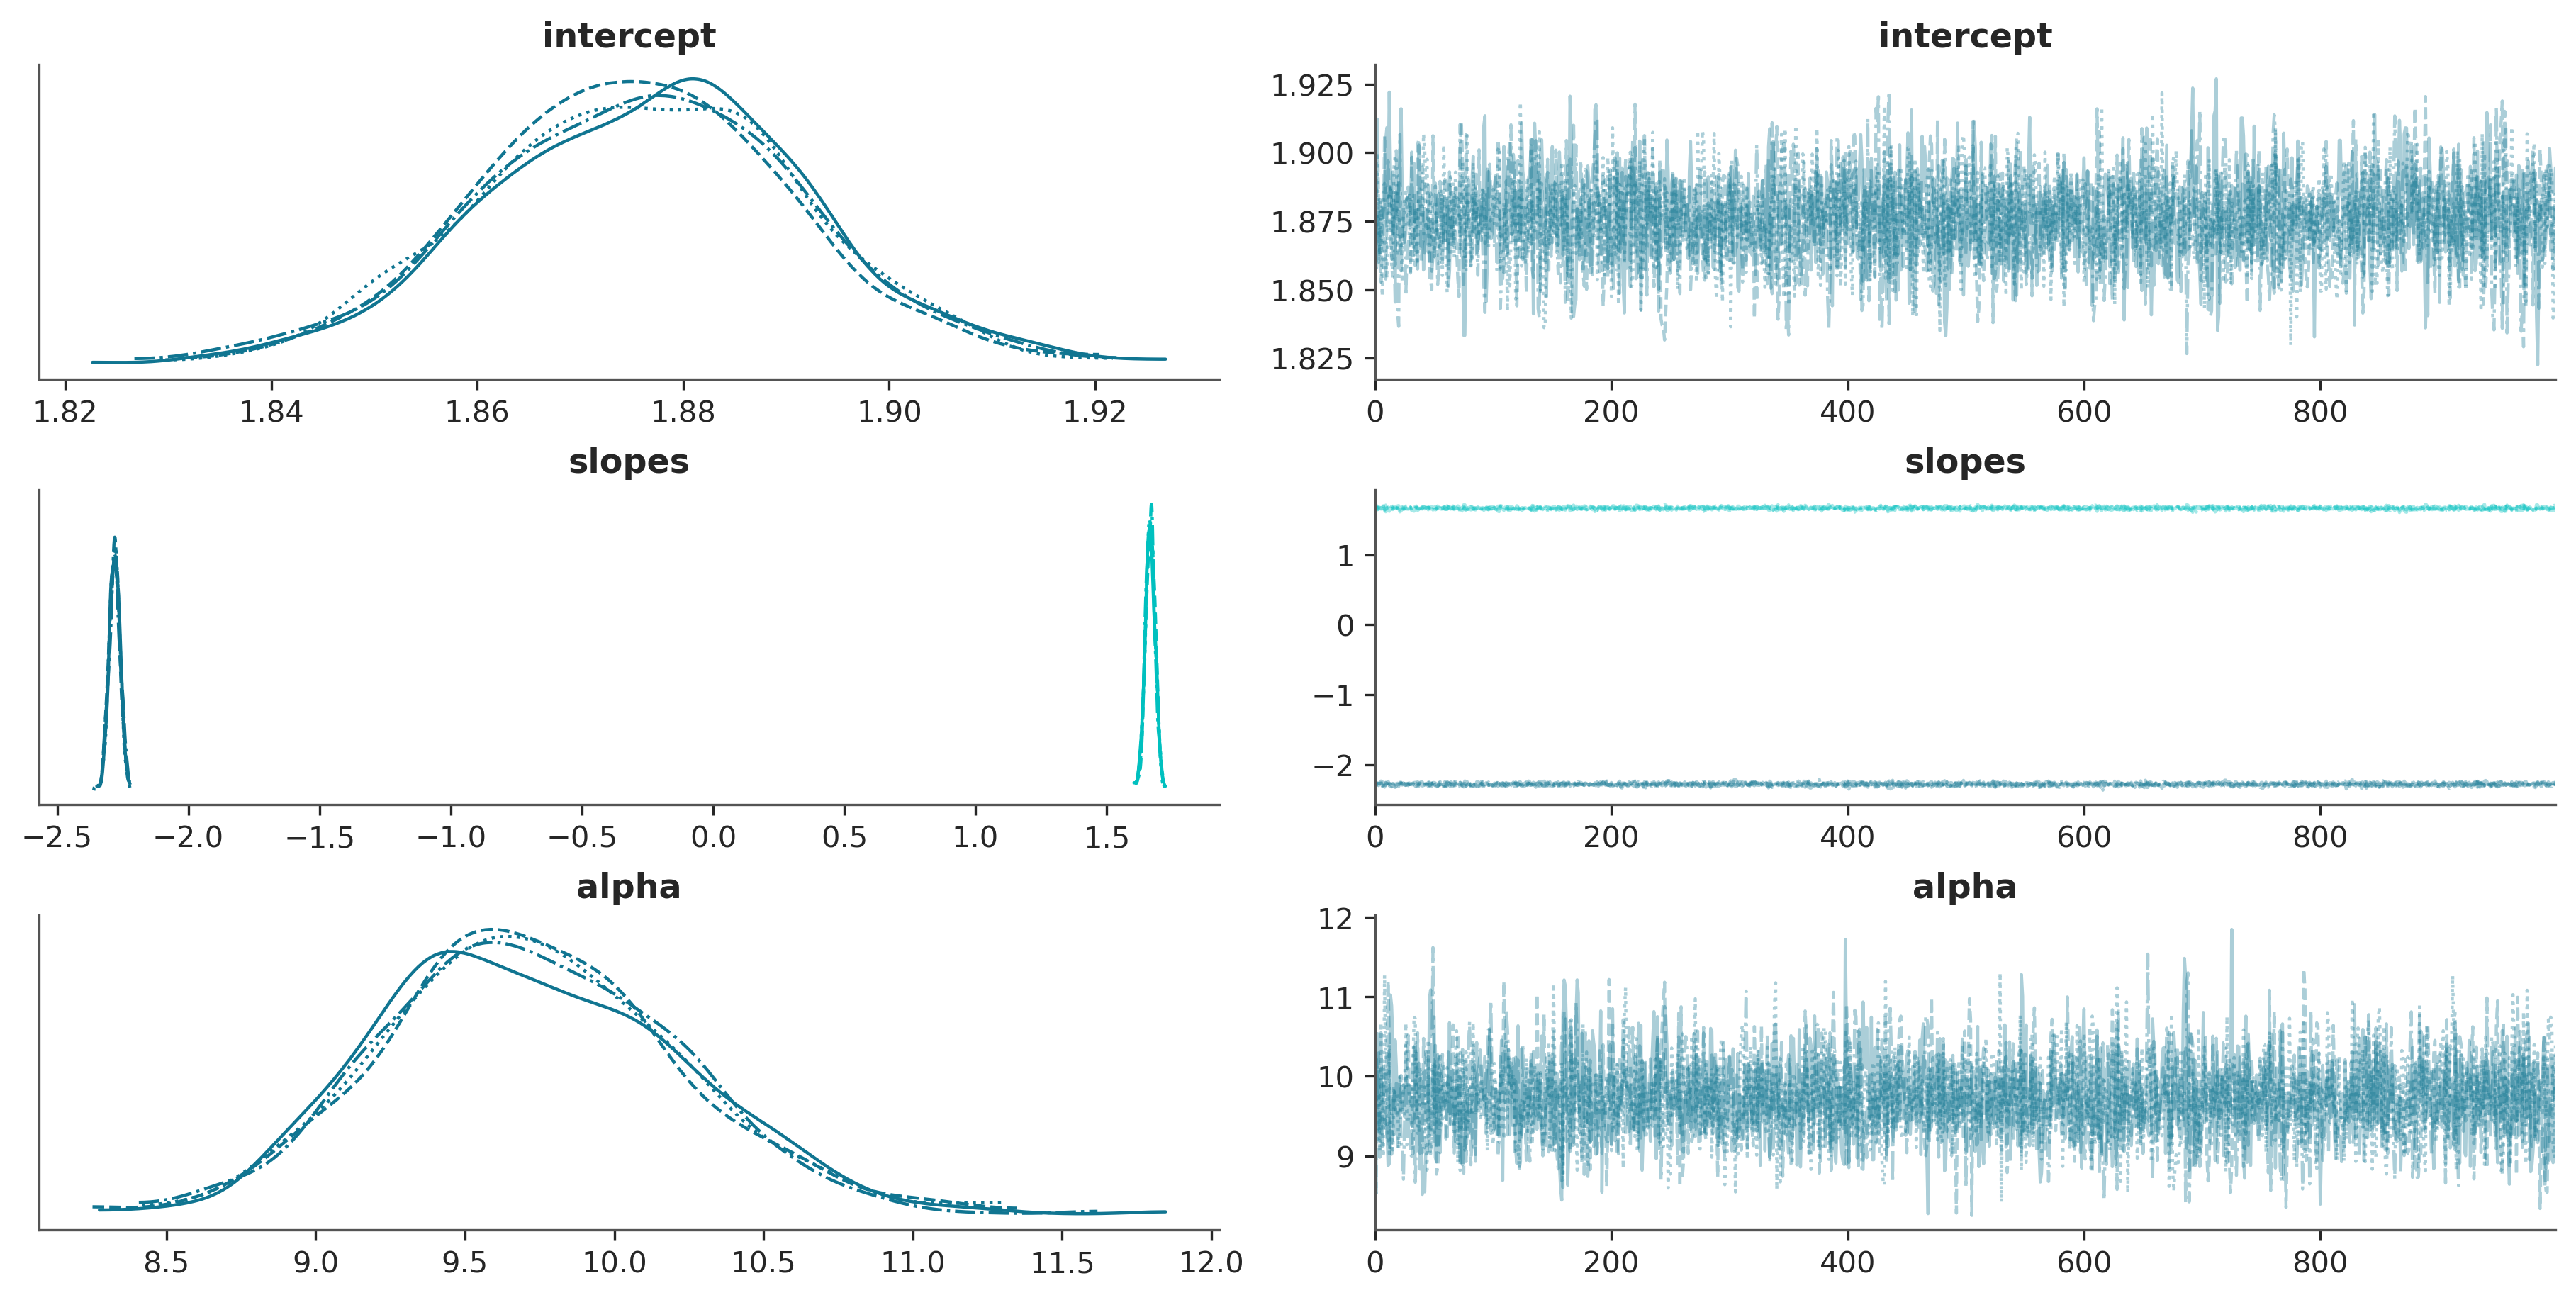

In [13]:
az.plot_trace(trace_sneeze_gp);

Sampling went well; let's quickly check the fit.

Sampling: [y]


Output()

/var/home/fonnesbeck/repos/instats_applied_bayes/.pixi/envs/default/lib/python3.13/site-packages/arviz/plots/ppcplot.py:242: FutureWarning:

color has been deprecated in favor of colors



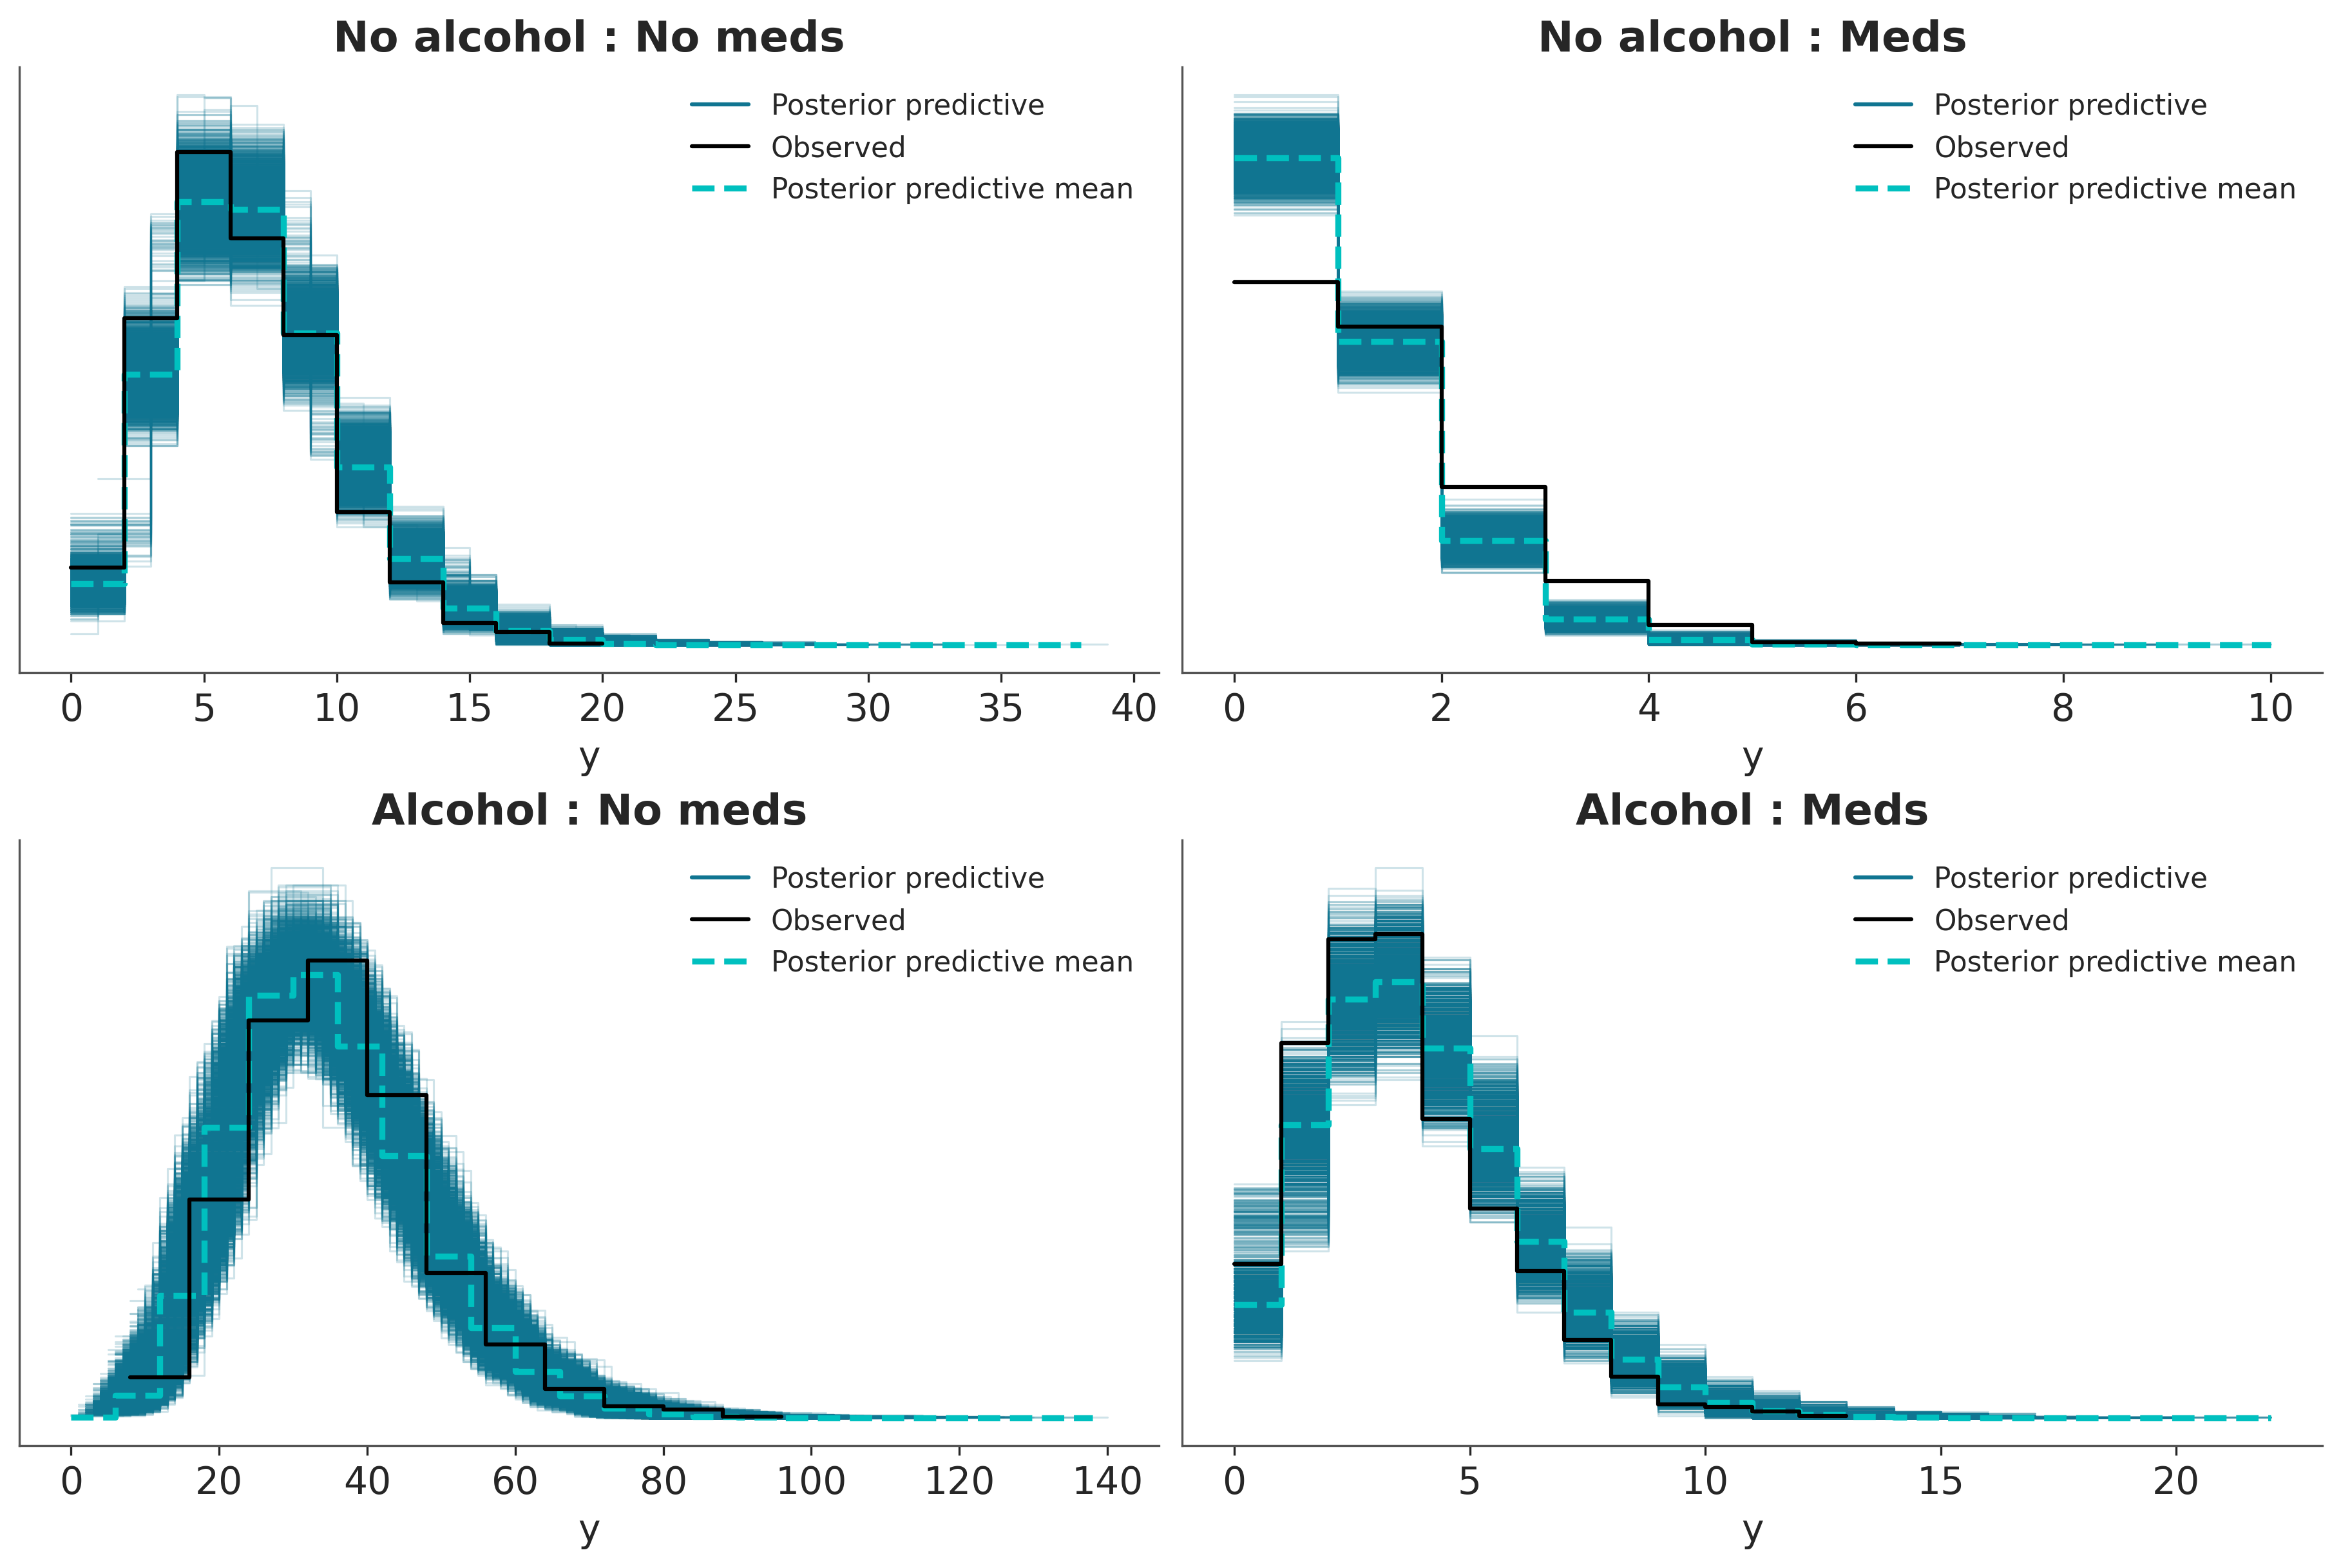

In [14]:
with m_sneeze_gp:
    trace_sneeze_gp.extend(pm.sample_posterior_predictive(trace_sneeze_gp))

plot_sneeze_predictions(trace_sneeze_gp);

### Exercise: Interaction effect

The predictions look much better than before, **but** we can see there is bias relative to the observations in some groups. For example, in the plot for no alcohol with medication the model is biased to predict fewer sneezes than we actually observe in the medication condition, and the opposite phenomenon in the no medication condition. 

This suggests that we are missing some sort of **interaction effect** between medication and alcohol consumption. The thing is that our model is only able to account for the mean sneezes across both conditions.

Try your hand at adding an interaction term to the model:

In [15]:
COORDS = {
		"regressor": ["meds", "alcohol", "meds : alcohol"], 
		"obs_idx": range(len(sneezes))
}
with pm.Model(coords=COORDS) as m_sneeze_inter:

    # weakly informative priors
    a = pm.Normal("intercept", mu=0, sigma=5)
    b = pm.Normal("slopes", mu=0, sigma=1, dims="regressor")
    alpha = pm.Exponential("alpha", 1.0)

    # define linear model
    mu = pm.math.exp(a + b[0] * M + b[1] * A + b[2] * M * A)

    ## likelihood
    y = pm.NegativeBinomial("y", mu=mu, alpha=alpha, observed=S, dims="obs_idx")

    trace_sneeze_inter = pm.sample()

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slopes, alpha]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 7 seconds.


We see that the slope for the interaction is reliably negative, meaning that taking meds when drinking alcohol will still tame the effects of the latter on sneezing and thus decrease the number of sneezes compared to not taking meds.

Sampling: [y]


Output()

/var/home/fonnesbeck/repos/instats_applied_bayes/.pixi/envs/default/lib/python3.13/site-packages/arviz/plots/ppcplot.py:242: FutureWarning:

color has been deprecated in favor of colors



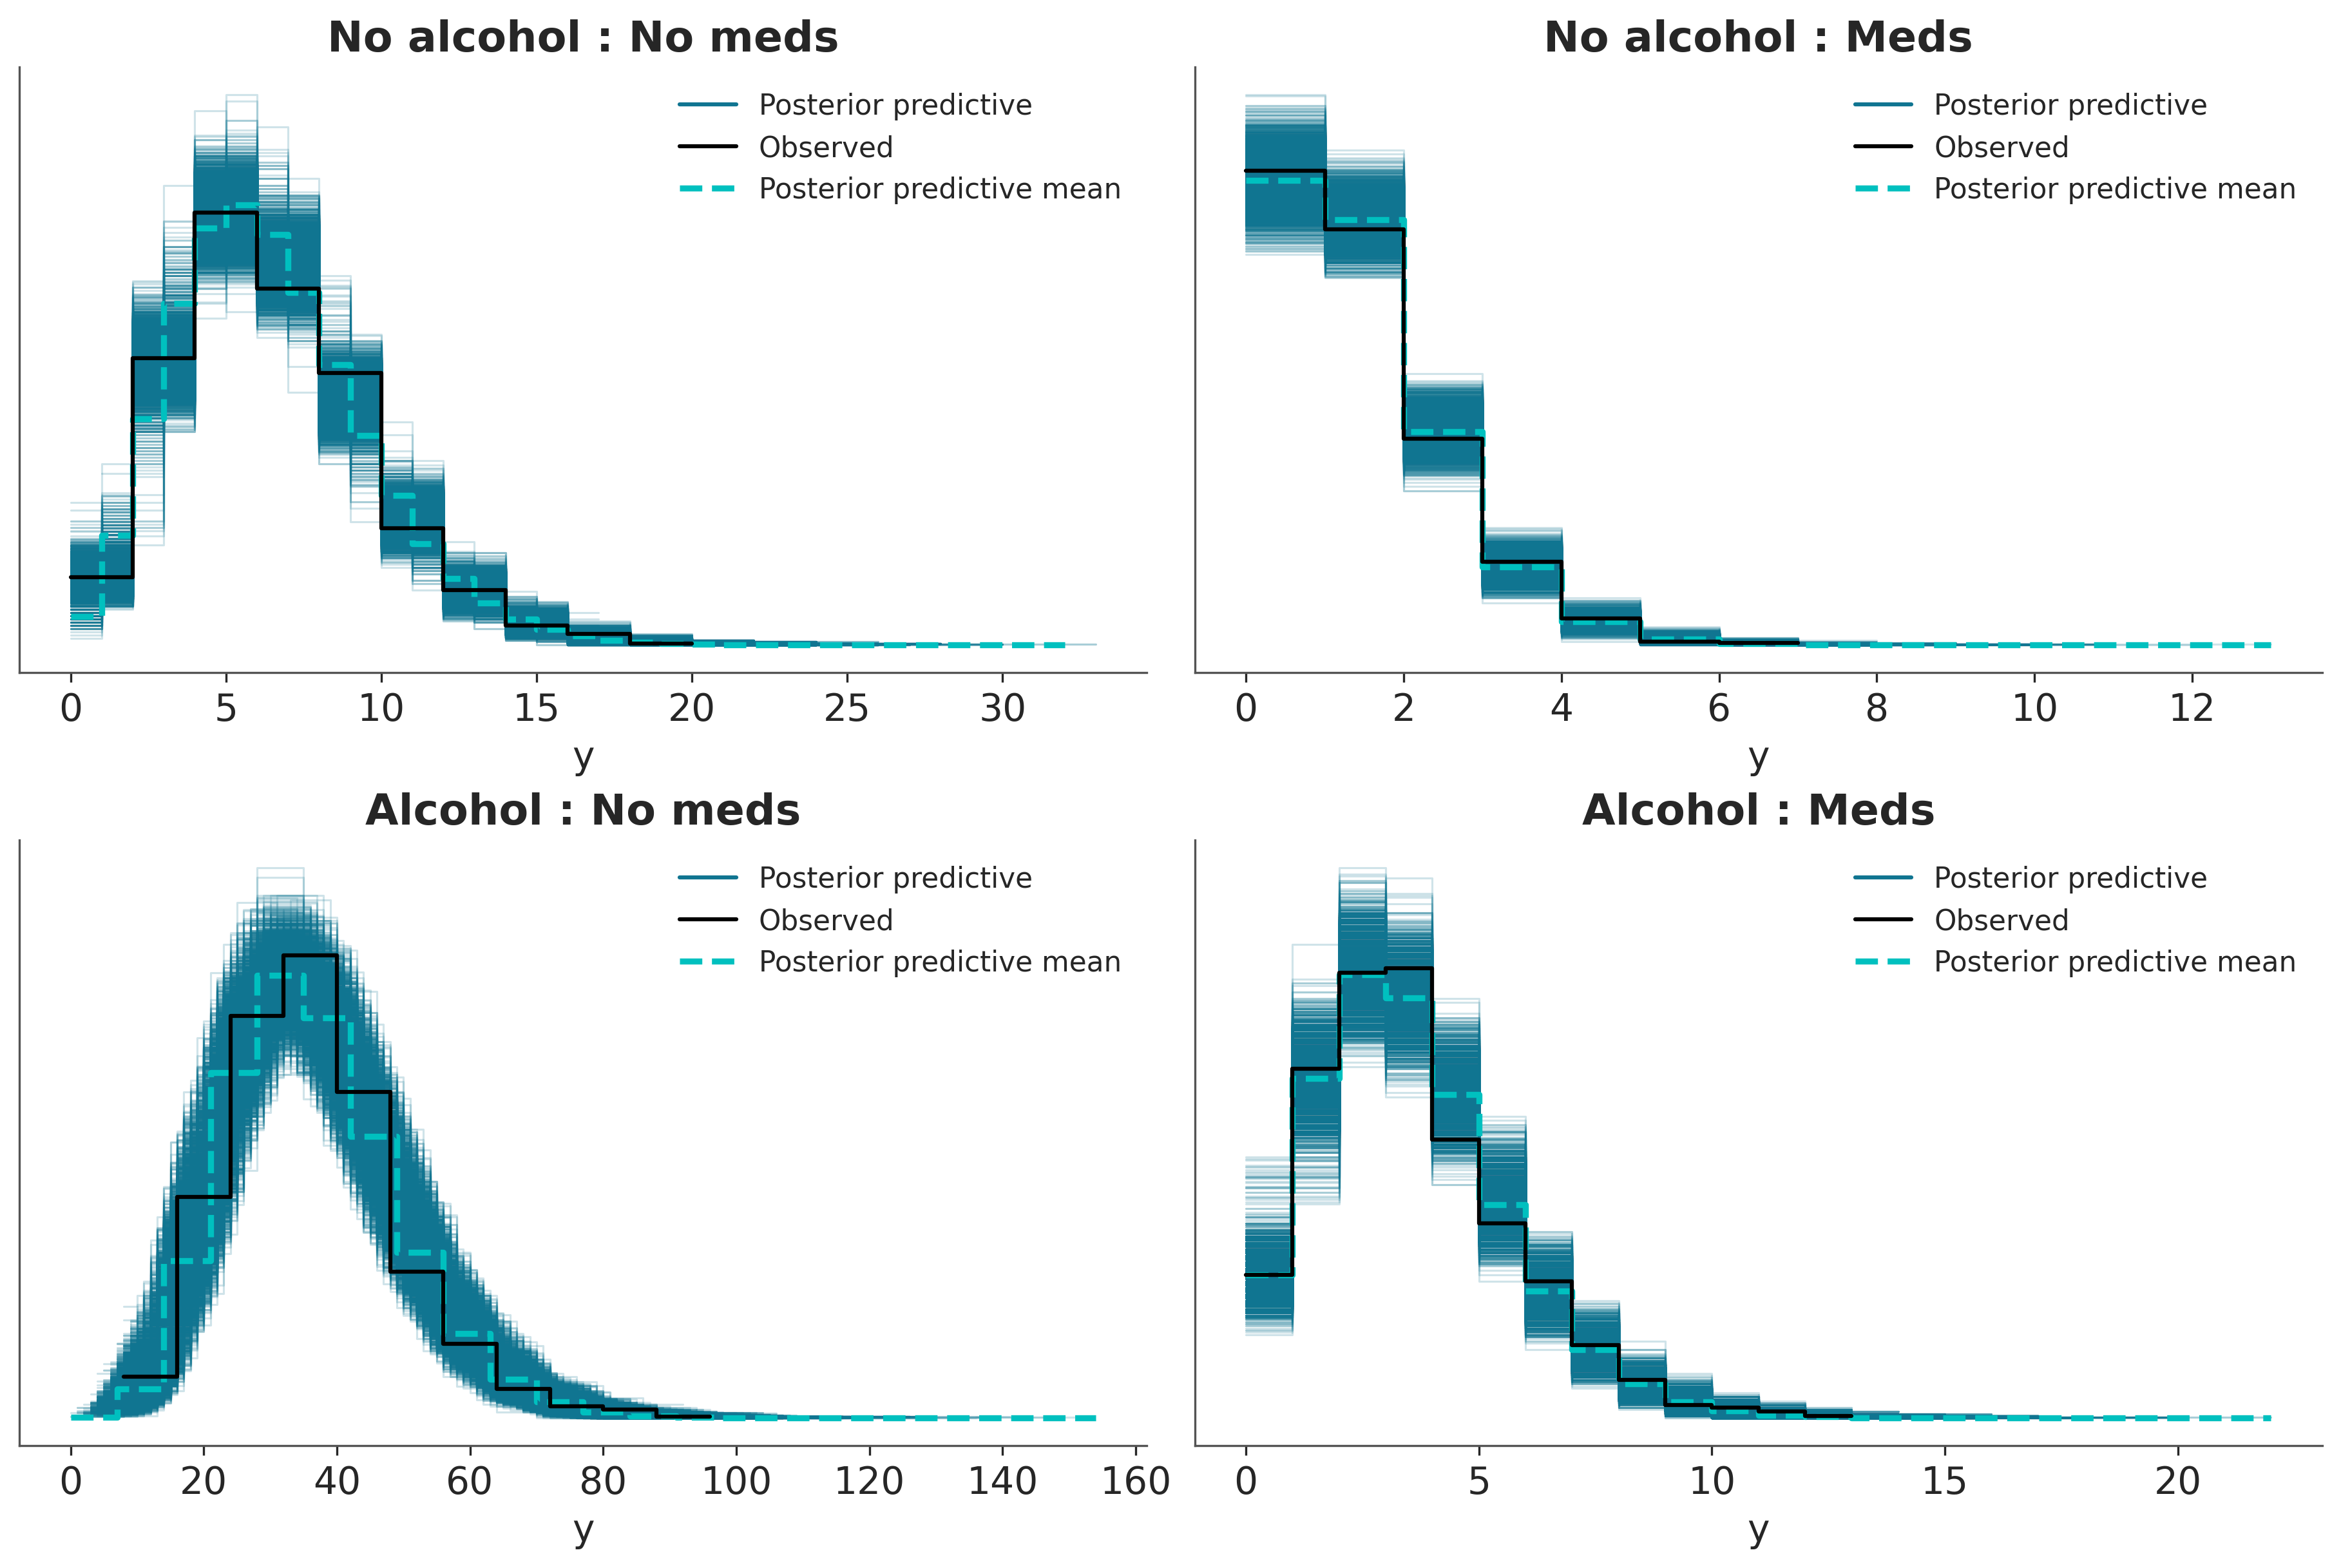

In [16]:
with m_sneeze_inter:
    trace_sneeze_inter.extend(pm.sample_posterior_predictive(trace_sneeze_inter))

plot_sneeze_predictions(trace_sneeze_inter);

We can see that the interaction term appears to have removed the biases, and the predictions look much better across the board.

## Generalized Linear Models 

Poisson and negative binomial regressions are particular types of **Generalized Linear Model**. 

### Linear Models

We assume the conditional distribution of the response variable is a normal distribution. We model the mean of that normal distribution with a linear combination of the predictors. Mathematically, we have

$$
\begin{aligned}
\pmb{\beta} &\sim \mathcal{P}_{\pmb{\beta}} \\
\sigma &\sim \mathcal{P}_\sigma \\
\mu_i &= \beta_0 + \beta_1 X_{1i} + \cdots + \beta_p X_{pi} \\
Y_i \mid \mu_i, \sigma &\sim \text{Normal}(\mu_i, \sigma)
\end{aligned}
$$

where $\mathcal{P}_{\pmb{\beta}}$ is the joint prior for the regression coefficients and $\mathcal{P}_\sigma$ is the prior on the residual standard deviation.

### Generalized Linear Models

In Generalized Linear Models, we are not restricted to normal likelihoods and we model a function of the mean with a linear combination of the predictors.

$$
\begin{aligned}
\pmb{\beta} &\sim \mathcal{P}_{\pmb{\beta}} \\
\pmb{\theta} &\sim \mathcal{P}_{\pmb{\theta}} \\
g(\mu_i) &= \eta_i = \beta_0 + \beta_1 X_{1i} + \cdots + \beta_p X_{pi} \\
Y_i \mid \mu_i, \pmb{\theta} &\sim \mathcal{D}(\mu_i, \pmb{\theta})
\end{aligned}
$$

Which consists of:

* $\eta_i = \beta_0 + \beta_1 X_{1i} + \cdots + \beta_p X_{pi}$ is the **linear predictor**
* $g$ is the **link function**
    * In the Poisson regression model $g$ is the $\log$ function.
    * This point raises a lot of questions, as we directly work with the inverse link function $g^{-1}$ ($\exp$ in the previous case)
    * $g: \Omega \to \mathbb{R}$
    * $g^{-1}: \mathbb{R} \to \Omega$
    * $\Omega$ is the space of the mean parameter
* $\mathcal{D}$ is the **sampling distribution**
    * The conditional distribution of the response variable $Y$
    * Is not necessarily normal

Linear models are specific case of generalized linear models where $\mathcal{D} \equiv \mathcal{N}$ and $g = I$ (*i.e.* the identity function).

## Hierarchical Models

Hierarchical or multilevel modeling is a generalization of regression modeling.

*Multilevel models* are regression models in which the constituent model parameters are given **probability models**. This implies that model parameters are allowed to **vary by group**.

Observational units are often naturally **clustered**. Clustering induces dependence between observations, despite random sampling of clusters and random sampling within clusters.

A *hierarchical model* is a particular multilevel model where parameters are nested within one another.

Some multilevel structures are not hierarchical. 

* e.g. "country" and "year" are not nested, but may represent separate, but overlapping, clusters of parameters

For this topic, let's revisit the radon dataset from the first section.


### Example: Radon contamination (Gelman and Hill 2006)

Radon is a radioactive gas that enters homes through contact points with the ground. It is a carcinogen that is the primary cause of lung cancer in non-smokers. Radon levels vary greatly from household to household.

![radon](images/how_radon_enters.jpg)

The EPA did a study of radon levels in 80,000 houses. Two important predictors:

* measurement in basement or first floor (radon higher in basements)
* county uranium level (positive correlation with radon levels)

We will focus on modeling radon levels in Minnesota.

The hierarchy in this example is households within county. 

### Data organization

First, we import the data and extract Minnesota's data.

In [17]:
import numpy as np
import polars as pl
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import seaborn as sns
import xarray as xr

sns.set_context("notebook")
import warnings

warnings.filterwarnings("ignore", module="mkl_fft")
warnings.filterwarnings("ignore", module="matplotlib")
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [18]:
DATA_URL = "https://raw.githubusercontent.com/pymc-labs/ccc-workshop/main/data/"

try:
    srrs2 = pl.read_csv("../data/srrs2.dat")
except FileNotFoundError:
    srrs2 = pl.read_csv(DATA_URL + "srrs2.dat")

# Import radon data

srrs2.columns = [col.strip() for col in srrs2.columns]
srrs_mn = srrs2.filter(pl.col("state") == "MN")

RANDOM_SEED = 20090425

HTTPError: HTTP Error 404: Not Found

Next, obtain the county-level predictor, uranium, by combining two variables.

In [ ]:
try:
    cty = pl.read_csv("../data/cty.dat")
except FileNotFoundError:
    cty = pl.read_csv(DATA_URL + "cty.dat")

srrs_mn = srrs_mn.with_columns(
    (
        pl.col("stfips").cast(pl.Float32) * 1000
        + pl.col("cntyfips").str.strip_chars().cast(pl.Float32)
    ).alias("fips")
)

cty_mn = cty.filter(pl.col("st") == "MN")
cty_mn = cty_mn.with_columns(
    (
        pl.col("stfips").cast(pl.Float32) * 1000 + pl.col("ctfips").cast(pl.Float32)
    ).alias("fips")
)

Use the `join` method to combine home- and county-level information in a single DataFrame.

In [ ]:
srrs_mn = srrs_mn.join(cty_mn[["fips", "Uppm"]], on="fips")
srrs_mn = srrs_mn.unique(subset="idnum")
u = np.log(srrs_mn["Uppm"]).unique().to_numpy()

srrs_mn.shape

We also need a lookup table (`dict`) for each unique county, for indexing.

In [ ]:
srrs_mn = srrs_mn.with_columns(pl.col("county").str.strip_chars().cast(pl.Categorical))
county = srrs_mn["county"].to_physical().to_numpy()
mn_counties = srrs_mn["county"].cat.get_categories()

Finally, create local copies of variables.

In [ ]:
srrs_mn = srrs_mn.with_columns(
    pl.col("activity").str.strip_chars().cast(pl.Float32).alias("radon")
)
srrs_mn = srrs_mn.with_columns(np.log(pl.col("radon") + 0.1).alias("log_radon"))
floor_measure = srrs_mn["floor"].to_numpy()

Distribution of radon levels in MN (log scale):

In [ ]:
srrs_mn.head()

In [ ]:
srrs_mn["log_radon"].plot.hist()

In [ ]:
srrs_mn["floor"].plot.hist()

## Conventional approaches

The two conventional alternatives to modeling radon exposure represent the two extremes of the bias-variance tradeoff:

***Complete pooling***: 

Treat all counties the same, and estimate a single radon level.

$$y_i = \alpha + \beta x_i + \epsilon_i$$

***No pooling***:

Model radon in each county independently.

$$y_i = \alpha_{j[i]} + \beta x_i + \epsilon_i$$

where $j[i]$ is the county index of observation $i$.

The errors $\epsilon_i$ may represent measurement error, temporal within-house variation, or variation among houses.

### Complete pooling

Here are the point estimates of the slope and intercept for the complete pooling model:

In [ ]:
log_radon = srrs_mn["log_radon"].to_numpy()
floor = srrs_mn["floor"].to_numpy()

In [ ]:
with pm.Model() as pooled_model:

    mu = pm.Normal("mu", 0, sigma=1e5)
    beta = pm.Normal("beta", mu=0, sigma=1e5)
    sigma = pm.HalfCauchy("sigma", 5)

    theta = mu + beta * floor

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon)

In [ ]:
pm.model_to_graphviz(pooled_model)

In [ ]:
with pooled_model:
    pooled_trace = pm.sample(random_seed=RANDOM_SEED)

In [ ]:
pooled_trace

In [ ]:
means = pooled_trace.posterior.mean(dim=("chain", "draw"))
mu_mean = means['mu'].values
beta_mean = means['beta'].values

In [ ]:
plt.scatter(srrs_mn["floor"], srrs_mn["log_radon"])
xvals = np.linspace(-0.2, 1.2)
yvals = mu_mean + beta_mean * xvals
plt.plot(xvals, yvals, "r--");

### No pooling

Estimates of county radon levels for the unpooled model.
Notice the use of `coords` to avoid manage dimensions.

In [ ]:
coords = {"county": mn_counties}

with pm.Model(coords=coords) as unpooled_model:

    mu = pm.Normal("mu", 0, sigma=1e5, dims="county")
    beta = pm.Normal("beta", 0, sigma=1e5)
    sigma = pm.HalfCauchy("sigma", 5)

    theta = mu[county] + beta * floor

    y = pm.Normal("y", theta, sigma=sigma, observed=log_radon)

In [ ]:
pm.model_to_graphviz(unpooled_model)

In [ ]:
with unpooled_model:
    unpooled_trace = pm.sample(random_seed=RANDOM_SEED)

In [ ]:
az.plot_forest(
    unpooled_trace,
    var_names=["mu"],
    combined=True,
    figsize=(6, 18),
);

In [ ]:
unpooled_estimates = unpooled_trace.posterior.mean(dim=("chain", "draw"))['mu']
unpooled_se = unpooled_trace.posterior.std(dim=("chain", "draw"))['mu']

We can plot the ordered estimates to identify counties with high radon levels:

In [ ]:
unpooled_means = unpooled_trace.posterior.mean(dim=("chain", "draw"))
unpooled_hdi = az.hdi(unpooled_trace)

unpooled_means_iter = unpooled_means.sortby("mu")
unpooled_hdi_iter = unpooled_hdi.sortby(unpooled_means_iter.mu)

_, ax = plt.subplots(figsize=(10, 6))
xticks = np.arange(0, 86, 6)
unpooled_means_iter.plot.scatter(x="county", y="mu", ax=ax, alpha=0.8)
ax.vlines(
    np.arange(mn_counties.shape[0]),
    unpooled_hdi_iter.mu.sel(hdi="lower"),
    unpooled_hdi_iter.mu.sel(hdi="higher"),
    color="orange",
    alpha=0.6,
)
ax.set(ylabel="Radon estimate", ylim=(-2, 4.5))
ax.set_xticks(xticks)
ax.set_xticklabels(unpooled_means_iter.county.values[xticks])
ax.tick_params(rotation=45)
sns.despine(trim=True);

Here are visual comparisons between the pooled and unpooled estimates for a subset of counties representing a range of sample sizes.

In [ ]:
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace.posterior.mean(dim=("chain", "draw")).beta
for i, c in enumerate(sample_counties):
    y, x = srrs_mn.filter(pl.col("county") == c)[["log_radon", "floor"]].to_numpy().T
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates.sel(county=c)

    # Plot both models and data
    xvals = np.linspace(0, 1)
    axes[i].plot(xvals, m.values * xvals + b.values)
    axes[i].plot(xvals, beta_mean * xvals + mu_mean, "r--")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

Neither of these models are satisfactory:

* if we are trying to identify high-radon counties, pooling is useless
* we do not trust extreme unpooled estimates produced by models using few observations

## Multilevel and hierarchical models

When we pool our data, we imply that they are sampled from the same model. This ignores any variation among sampling units (other than sampling variance):

![pooled](images/pooled_model.png)

When we analyze data unpooled, we imply that they are sampled independently from separate models. At the opposite extreme from the pooled case, this approach claims that differences between sampling units are to large to combine them:

![unpooled](images/unpooled_model.png)

In a hierarchical model, parameters are viewed as a sample from a population distribution of parameters. Thus, we view them as being neither entirely different or exactly the same. This is ***parital pooling***.

![hierarchical](images/partial_pooled_model.png)

We can use PyMC to easily specify multilevel models, and fit them using Markov chain Monte Carlo.

## Partial pooling model

The simplest partial pooling model for the household radon dataset is one which simply estimates radon levels, without any predictors at any level. A partial pooling model represents a compromise between the pooled and unpooled extremes, approximately a weighted average (based on sample size) of the unpooled county estimates and the pooled estimates.

$$\hat{\alpha} \approx \frac{(n_j/\sigma_y^2)\bar{y}_j + (1/\sigma_{\alpha}^2)\bar{y}}{(n_j/\sigma_y^2) + (1/\sigma_{\alpha}^2)}$$

Estimates for counties with smaller sample sizes will shrink towards the state-wide average.

Estimates for counties with larger sample sizes will be closer to the unpooled county estimates.

In [ ]:
with pm.Model(coords=coords) as partial_pooling:

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=1e5)
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # Random intercepts
    mu = pm.Normal("mu", mu=mu_a, sigma=sigma_a, dims="county")

    # Model error
    sigma_y = pm.HalfCauchy("sigma_y", 5)

    # Expected value
    y_hat = mu[county]

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon)

In [ ]:
pm.model_to_graphviz(partial_pooling)

In [ ]:
with partial_pooling:
    partial_pooling_trace = pm.sample(tune=2000, random_seed=21)

In [ ]:
N_county = srrs_mn.group_by("county").agg(pl.col("idnum").count())["idnum"].to_numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharex=True, sharey=True)
for ax, trace, level in zip(
    axes,
    (unpooled_trace, partial_pooling_trace),
    ("no pooling", "partial pooling"),
):

    # add variable with x values to xarray dataset
    trace.posterior = trace.posterior.assign_coords({"N_county": ("county", N_county)})
    # plot means
    trace.posterior.mean(dim=("chain", "draw")).plot.scatter(
        x="N_county", y="mu", ax=ax, alpha=0.9
    )
    ax.hlines(
        partial_pooling_trace.posterior.mu.mean(),
        0.9,
        max(N_county) + 1,
        alpha=0.4,
        ls="--",
        label="Est. population mean",
    )

    # plot hdi
    hdi = az.hdi(trace).mu
    ax.vlines(
        N_county, hdi.sel(hdi="lower"), hdi.sel(hdi="higher"), color="orange", alpha=0.5
    )

    ax.set(
        title=f"{level.title()} Estimates",
        xlabel="Nbr obs in county (log scale)",
        xscale="log",
        ylabel="Log radon",
    )
    ax.legend(fontsize=10)

Notice the difference between the unpooled and partially-pooled estimates, particularly at smaller sample sizes. The former are both more extreme and more imprecise.

## Varying intercept model

This model allows intercepts to vary across county, according to a random effect.

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

where

$$\epsilon_i \sim N(0, \sigma_y^2)$$

and the intercept random effect:

$$\alpha_{j[i]} \sim N(\mu_{\alpha}, \sigma_{\alpha}^2)$$

As with the the “no-pooling” model, we set a separate intercept for each county, but rather than fitting separate least squares regression models for each county, multilevel modeling **shares strength** among counties, allowing for more reasonable inference in counties with little data.

### Exercise

Modify the previous model to include a shared slope, `beta`.

In [ ]:
with pm.Model(coords=coords) as varying_intercept:

    # Write your code here

In [ ]:
pm.model_to_graphviz(varying_intercept)

In [ ]:
with varying_intercept:
    varying_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

In [ ]:
pm.plot_forest(
    varying_intercept_trace,
    var_names=["mu"],
    figsize=(6, 18),
    combined=True,
);

The estimate for the `floor` coefficient is approximately -0.66, which can be interpreted as measurements taken on a floor, rather than in a basement, having about half ($\exp(-0.66) = 0.52$) the radon levels after accounting for county.

In [ ]:
az.summary(varying_intercept_trace, var_names=["beta"])

In [ ]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_trace.posterior  # alias for readability
theta = (
    (post.mu + post.beta * xvals)
    .mean(dim=("chain", "draw"))
    .to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(
    x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax
)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

It is easy to show that the partial pooling model provides more objectively reasonable estimates than either the pooled or unpooled models, at least for counties with small sample sizes.

In [ ]:
sample_counties = (
    "LAC QUI PARLE",
    "AITKIN",
    "KOOCHICHING",
    "DOUGLAS",
    "CLAY",
    "STEARNS",
    "RAMSEY",
    "ST LOUIS",
)

fig, axes = plt.subplots(2, 4, figsize=(12, 6), sharey=True, sharex=True)
axes = axes.ravel()
m = unpooled_trace.posterior.mean(dim=("chain", "draw")).beta
for i, c in enumerate(sample_counties):
    y, x = srrs_mn.filter(pl.col("county") == c)[["log_radon", "floor"]].to_numpy().T
    axes[i].scatter(x + np.random.randn(len(x)) * 0.01, y, alpha=0.4)

    # No pooling model
    b = unpooled_estimates.sel(county=c)

    # Plot both models and data
    xvals = np.linspace(0, 1)
    axes[i].plot(xvals, m.values * xvals + b.values)
    axes[i].plot(xvals, beta_mean * xvals + mu_mean, "r--")
    varying_intercept_trace.posterior.sel(county=c).beta
    post = varying_intercept_trace.posterior.sel(county=c).mean(dim=("chain", "draw"))
    theta = post.mu.values + post.beta.values * xvals
    axes[i].plot(xvals, theta, "k:")
    axes[i].set_xticks([0, 1])
    axes[i].set_xticklabels(["basement", "floor"])
    axes[i].set_ylim(-1, 3)
    axes[i].set_title(c)
    if not i % 2:
        axes[i].set_ylabel("log radon level")

### Exercise: Varying slope model

Alternatively, we can posit a model that allows the counties to vary according to how the location of measurement (basement or floor) influences the radon reading.

$$y_i = \alpha + \beta_{j[i]} x_{i} + \epsilon_i$$

Construct a model called `varying_slope` that implements this alternative model.


In [ ]:
with pm.Model(coords=coords) as varying_slope:

    # Write your code here

In [ ]:
with varying_slope:
    varying_slope_trace = pm.sample(tune=3000)

## Non-centered Parameterization

The partial pooling models specified above uses a **centered** parameterization of the slope random effect. That is, the individual county effects are distributed around a county mean, with a spread controlled by the hierarchical standard deviation parameter. As the preceding plot reveals, this constraint serves to **shrink** county estimates toward the overall mean, to a degree proportional to the county sample size. This is exactly what we want, and the model appears to fit well--the Gelman-Rubin statistics are exactly 1.

But, on closer inspection, there are signs of trouble. Specifically, let's look at the trace of the random effects, and their corresponding standard deviation:

In [ ]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(varying_slope_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(varying_slope_trace.posterior.sel(chain=0)["beta"], alpha=0.05)
axs[1].set(ylabel="beta");

Notice that when the chain reaches the lower end of the parameter space for $\sigma_b$, it appears to get "stuck" and the entire sampler, including the random slopes `b`, mixes poorly. 

Jointly plotting the random effect variance and one of the individual random slopes demonstrates what is going on.

In [ ]:
x = varying_slope_trace.posterior["beta"].sel(chain=0, county="AITKIN").to_series()
x.name = "slope"
y = varying_slope_trace.posterior["sigma_b"].sel(chain=0).to_series()
y.name = "slope group variance"

jp = sns.jointplot(x=x, y=y, ylim=(0, 0.7));

When the group variance is small, this implies that the individual random slopes are themselves close to the group mean. This results in a *funnel*-shaped relationship between the samples of group variance and any of the slopes (particularly those with a smaller sample size). 

In itself, this is not a problem, since this is the behavior we expect. However, if the sampler is tuned for the wider (unconstrained) part of the parameter space, it has trouble in the areas of higher curvature. The consequence of this is that the neighborhood close to the lower bound of $\sigma_b$ is sampled poorly; indeed, in our chain it is not sampled at all below 0.1. The result of this will be biased inference.

Now that we've spotted the problem, what can we do about it? The best way to deal with this issue is to reparameterize our model. Notice the random slopes in this version:

In [ ]:
with pm.Model(coords=coords) as varying_slope_noncentered:

    # Priors
    mu_b = pm.Normal("mu_b", mu=0.0, sigma=1e5)
    sigma_b = pm.HalfCauchy("sigma_b", 5)

    # Common intercepts
    mu = pm.Normal("mu", mu=0.0, sigma=1e5)

    # Non-centered random slopes
    # Centered: b = pm.Normal('b', mu_b, sigma=sigma_b, shape=counties)
    z = pm.Normal("z", mu=0, sigma=1, dims="county")
    beta = pm.Deterministic("beta", mu_b + z * sigma_b, dims="county")

    # Model error
    sigma_y = pm.HalfCauchy("sigma_y", 5)

    # Expected value
    y_hat = mu + beta[county] * floor_measure

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon)

In [ ]:
pm.model_to_graphviz(varying_slope_noncentered)

This is a **non-centered** parameterization. By this, we mean that the random deviates are no longer explicitly modeled as being centered on $\mu_b$. Instead, they are independent standard normals $\upsilon$, which are then scaled by the appropriate value of $\sigma_b$, before being location-transformed by the mean.

This model samples much better.

In [ ]:
with varying_slope_noncentered:
    noncentered_trace = pm.sample(
        tune=3000, target_accept=0.99, random_seed=RANDOM_SEED
    )

Notice that the bottlenecks in the traces are (mostly) gone.

In [ ]:
fig, axs = plt.subplots(nrows=2)
axs[0].plot(noncentered_trace.posterior.sel(chain=0)["sigma_b"], alpha=0.5)
axs[0].set(ylabel="sigma_b")
axs[1].plot(noncentered_trace.posterior.sel(chain=0)["beta"], alpha=0.05)
axs[1].set(ylabel="beta");

And, we are now fully exploring the support of the posterior.

In [ ]:
x = noncentered_trace.posterior["beta"].sel(chain=0, county="AITKIN").to_series()
x.name = "slope"
y = noncentered_trace.posterior["sigma_b"].sel(chain=0).to_series()
y.name = "slope group variance"

jp = sns.jointplot(x=x, y=y, ylim=(0, 0.7));

In [ ]:
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True, constrained_layout=True)
az.plot_posterior(varying_slope_trace, var_names=["sigma_b"], ax=ax1)
az.plot_posterior(noncentered_trace, var_names=["sigma_b"], ax=ax2)
ax1.set_title("Centered (top) and non-centered (bottom)");

## Varying intercept and slope model

The most general model allows both the intercept and slope to vary by county:

$$y_i = \alpha_{j[i]} + \beta_{j[i]} x_{i} + \epsilon_i$$


In [ ]:
with pm.Model(coords=coords) as varying_intercept_slope:

    # Priors
    mu_a = pm.Normal("mu_a", mu=0.0, sigma=1e5)
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    mu_b = pm.Normal("mu_b", mu=0.0, sigma=1e5)
    sigma_b = pm.HalfCauchy("sigma_b", 5)

    # Random intercepts
    mu = pm.Normal("mu", mu=mu_a, sigma=sigma_a, dims="county")
    
    # Random slopes
    beta = pm.Normal("beta", mu=mu_b, sigma=sigma_b, dims="county")

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = mu[county] + beta[county] * floor_measure

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon)

In [ ]:
with varying_intercept_slope:
    varying_intercept_slope_trace = pm.sample(tune=4000, random_seed=RANDOM_SEED)

In [ ]:
az.plot_forest(
    varying_intercept_slope_trace,
    var_names=["mu", "beta"],
    figsize=(6, 24),
    combined=True,
    ess=True,
    r_hat=True,
);

In [ ]:
xvals = xr.DataArray([0, 1], dims="Level", coords={"Level": ["Basement", "Floor"]})
post = varying_intercept_slope_trace.posterior  # alias for readability
theta = (
    (post.mu + post.beta * xvals)
    .mean(dim=("chain", "draw"))
    .to_dataset(name="Mean log radon")
)

_, ax = plt.subplots()
theta.plot.scatter(
    x="Level", y="Mean log radon", alpha=0.2, color="k", ax=ax
)  # scatter
ax.plot(xvals, theta["Mean log radon"].T, "k-", alpha=0.2)
# add lines too
ax.set_title("MEAN LOG RADON BY COUNTY");

### Exercise

Reparameterize the `varying_intercept_slope` model to be non-centered, and compare the resulting parameter estimates.

In [ ]:
with pm.Model(coords=coords) as varying_intercept_slope_noncentered:

    # Write your code here

## Adding group-level predictors

A primary strength of multilevel models is the ability to handle predictors on multiple levels simultaneously. If we consider the varying-intercepts model above:

$$y_i = \alpha_{j[i]} + \beta x_{i} + \epsilon_i$$

we may, instead of a simple random effect to describe variation in the expected radon value, specify another regression model with a county-level covariate. Here, we use the county uranium reading $u_j$, which is thought to be related to radon levels:

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \zeta_j$$

$$\zeta_j \sim N(0, \sigma_{\alpha}^2)$$

Thus, we are now incorporating a house-level predictor (floor or basement) as well as a county-level predictor (uranium).

Note that the model has both indicator variables for each county, plus a county-level covariate. In classical regression, this would result in collinearity. In a multilevel model, the partial pooling of the intercepts towards the expected value of the group-level linear model avoids this.

Group-level predictors also serve to reduce group-level variation $\sigma_{\alpha}$. An important implication of this is that the group-level estimate induces stronger pooling.

In [ ]:
with pm.Model(coords=coords) as hierarchical_intercept:

    # Priors
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # County uranium model
    gamma_0 = pm.Normal("gamma_0", mu=0.0, sigma=1e5)
    gamma_1 = pm.Normal("gamma_1", mu=0.0, sigma=1e5)

    # Uranium model for intercept
    mu_a = pm.Deterministic("mu_a", gamma_0 + gamma_1 * u)
    
    # County variation not explained by uranium
    epsilon_a = pm.Normal("epsilon_a", mu=0, sigma=1, dims="county")
    mu = pm.Deterministic("mu", mu_a + sigma_a * epsilon_a)

    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=1e5)

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = mu[county] + beta * floor_measure

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=log_radon)

In [ ]:
with hierarchical_intercept:
    hierarchical_intercept_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

In [ ]:
az.plot_trace(hierarchical_intercept_trace, var_names="gamma_1")

In [ ]:
uranium = u
post = hierarchical_intercept_trace.posterior.assign_coords(uranium=uranium)
avg_a = post["mu_a"].mean(dim=("chain", "draw")).values[np.argsort(uranium)]
avg_a_county = post["mu"].mean(dim=("chain", "draw"))
avg_a_county_hdi = az.hdi(post, var_names="mu")["mu"]

_, ax = plt.subplots()
ax.plot(uranium[np.argsort(uranium)], avg_a, "k--", alpha=0.6, label="Mean intercept")
az.plot_hdi(
    uranium,
    post["mu"],
    fill_kwargs={"alpha": 0.1, "color": "k", "label": "Mean intercept HPD"},
    ax=ax,
)
ax.scatter(uranium, avg_a_county, alpha=0.8, label="Mean county-intercept")
ax.vlines(
    uranium,
    avg_a_county_hdi.sel(hdi="lower"),
    avg_a_county_hdi.sel(hdi="higher"),
    alpha=0.5,
    color="orange",
)
plt.xlabel("County-level uranium")
plt.ylabel("Intercept estimate")
plt.legend(fontsize=9);

The standard errors on the intercepts are narrower than for the partial-pooling model without a county-level covariate.

### Correlations among levels

In some instances, having predictors at multiple levels can reveal correlation between individual-level variables and group residuals. We can account for this by including the average of the individual predictors as a covariate in the model for the group intercept.

$$\alpha_j = \gamma_0 + \gamma_1 u_j + \gamma_2 \bar{x} + \zeta_j$$

These are broadly referred to as ***contextual effects***.

In [ ]:
# Create new variable for mean of floor across counties
xbar = srrs_mn.group_by("county").agg(pl.col("floor").mean())["floor"].to_numpy()

In [ ]:
with pm.Model(coords=coords) as contextual_effect:

    floor_idx = pm.Data("floor_idx", floor.astype(int))
    county_idx = pm.Data("county_idx", county.astype(int))
    radon_data = pm.Data("radon_data", log_radon)

    # Priors
    sigma_a = pm.HalfCauchy("sigma_a", 5)

    # County uranium model for slope
    # gamma = pm.Normal('gamma', mu=0., sigma=1e5, shape=3)
    gamma = pm.Normal("gamma", mu=0.0, sigma=1e5)

    # Uranium model for intercept
    # mu_a = pm.Deterministic('mu_a', gamma[0] + gamma[1]*u + gamma[2]*xbar)
    mu_a = pm.Deterministic("mu_a", gamma)

    # County variation not explained by uranium
    epsilon_a = pm.Normal("epsilon_a", mu=0, sigma=1, dims="county")
    mu = pm.Deterministic("mu", mu_a + sigma_a * epsilon_a)

    # Common slope
    beta = pm.Normal("beta", mu=0.0, sigma=1e15)

    # Model error
    sigma_y = pm.Uniform("sigma_y", lower=0, upper=100)

    # Expected value
    y_hat = mu[county_idx] + beta * floor_idx

    # Data likelihood
    y_like = pm.Normal("y_like", mu=y_hat, sigma=sigma_y, observed=radon_data)

In [ ]:
pm.model_to_graphviz(contextual_effect)

In [ ]:
with contextual_effect:
    contextual_effect_trace = pm.sample(tune=2000, random_seed=RANDOM_SEED)

In [ ]:
az.plot_forest(
    contextual_effect_trace, var_names=["gamma"], combined=True, ess=True, r_hat=True
);

In [ ]:
az.summary(contextual_effect_trace, var_names=["gamma"])

So, we might infer from this that counties with higher proportions of houses without basements tend to have higher baseline levels of radon. Perhaps this is related to the soil type, which in turn might influence what type of structures are built.

### Prediction

There are two types of prediction that can be made in a multilevel model:

1. a new individual within an existing group
2. a new individual within a new group

For example, if we wanted to make a prediction for a new house with no basement in St. Louis and Kanabec counties, we just need to sample from the radon model with the appropriate intercept.

That is, 

$$\tilde{y}_i \sim N(\alpha_{69} + \beta (x_i=1), \sigma_y^2)$$

Because we judiciously set the county index and floor values as shared variables earlier, we can modify them directly to the desired values (69 and 1 respectively) and sample corresponding posterior predictions, without having to redefine and recompile our model. Using the model just above:

In [ ]:
prediction_coords = {"obs_id": ["ST LOUIS", "KANABEC"]}
with contextual_effect:
    pm.set_data(
        {
            "county_idx": np.array([69, 31]),
            "floor_idx": np.array([1, 1]),
            "radon_data": np.ones(2),
        }
    )
    stl_pred = pm.sample_posterior_predictive(contextual_effect_trace.posterior)

contextual_effect_trace.extend(stl_pred)

In [ ]:
contextual_effect_trace

In [ ]:
az.plot_posterior(contextual_effect_trace, group="posterior_predictive");

Prediction for a house within a new county is a little trickier. It is actually easier to create a new model to work with, **but use the trace from the original model for posterior predictive sampling**. 

How can this work?

First, consider how posterior predictive sampling works in PyMC: samples are drawn not from the distributions themselves, but from the set of samples in the trace. Therefore, we can take the trace from the original model, and use it to sample posterior predictions from a new model that has the same variables.

The variables in the new model need only have the same name as the original -- to reinforce this, I will use `pm.Flat` variables as placeholders in this example. The only variables we actually need are the ones that need to be resampled for a new county.

We don't even need `Data` here; we can use raw data, since we are just creating this model to get posterior predictions for houses in this notional new county.

In [ ]:
with pm.Model() as new_county_house:

    # New data
    # u_new = np.array([-0.2, 0.3])
    # xbar = np.array([0.5, 0.8])
    floor_idx = np.array([1, 0])

    # Placeholders for variables already in the trace
    sigma_a = pm.Flat("sigma_a")
    gamma = pm.Flat("gamma")  # , shape=3)
    beta = pm.Flat("beta")
    sigma_y = pm.Flat("sigma_y")

    # Calculate new county expected value
    mu_a_new = pm.Deterministic(
        "mu_a_new", gamma
    )  # [0] + gamma[1]*u_new + gamma[2]*xbar)

    # Sample from the county intercept distribution
    mu_new = pm.Normal("mu_new", mu_a_new, sigma_a)

    # Expected value for houses in new county
    y_hat_new = mu_new + beta * floor_idx

    y_new = pm.Normal("y_new", mu=y_hat_new, sigma=sigma_y)

    pp_new = pm.sample_posterior_predictive(
        contextual_effect_trace, var_names=["y_new"]
    )

In [ ]:
pm.model_to_graphviz(new_county_house)

## Benefits of Multilevel Models

- Accounting for natural hierarchical structure of observational data
- Estimation of coefficients for (under-represented) groups
- Incorporating individual- and group-level information when estimating group-level coefficients
- Allowing for variation among individual-level coefficients across groups


---
## References

Gelman, A., & Hill, J. (2006). Data Analysis Using Regression and Multilevel/Hierarchical Models (1st ed.). Cambridge University Press.

Betancourt, M. J., & Girolami, M. (2013). Hamiltonian Monte Carlo for Hierarchical Models.

Gelman, A. (2006). Multilevel (Hierarchical) modeling: what it can and cannot do. Technometrics, 48(3), 432–435.

In [ ]:
%load_ext watermark
%watermark -n -u -v -iv -w